In [1]:
import random
import torch
from tqdm import tqdm
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np

device = "cuda" if torch.cuda.is_available() else "cpu"

In [58]:
# helper functions
def set_all_seeds(seed=42):
    # 1) Python built-in
    random.seed(seed)
    # 2) NumPy
    np.random.seed(seed)
    # 3) PyTorch CPU
    torch.manual_seed(seed)
    # 4) PyTorch GPU
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  # if using multi-GPU

    # 5) Make PyTorch cudnn reproducible (might impact performance)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def cosine_similarity(tensor1: torch.Tensor, tensor2: torch.Tensor):
    # Flatten tensors for calculations
    t1_flat = tensor1.view(-1)
    t2_flat = tensor2.view(-1)
    
    # Calculate cosine similarity
    cosine_sim = F.cosine_similarity(t1_flat.unsqueeze(0), t2_flat.unsqueeze(0))
    
    return cosine_sim.item()

def normalize(tensor: torch.Tensor):
    # Min-max normalization to [0, 1] range
    min_val = tensor.min()
    max_val = tensor.max()
    normalized = (tensor - min_val) / (max_val - min_val + 1e-8)
        
    return normalized

def downscale_activity(activity: torch.Tensor, ds: int) -> torch.Tensor:
    """
    Downscale a 2D tensor `activity` by a factor of `ds` using block averaging.
    activity.shape = (N, N)
    ds must divide N.
    Returns a coarse-grained tensor of shape (N//ds, N//ds).
    """
    if isinstance(activity, np.ndarray):
        activity = torch.from_numpy(activity)
    activity = activity.to(torch.float32)
    N = activity.shape[0]
    assert N % ds == 0, f"Downscale factor ds={ds} must evenly divide dimension N={N}."

    x = activity.unsqueeze(0).unsqueeze(0)  # => (1,1,N,N)
    x_pooled = F.avg_pool2d(x, kernel_size=ds, stride=ds)  # => (1,1,N//ds,N//ds)
    
    # shape => (N//ds, N//ds)
    return x_pooled.squeeze(0).squeeze(0)

def upscale_activity(activity, ds: int) -> torch.Tensor:
    """
    Upscale a 2D array by factor ds using nearest-neighbor replication.
    If activity is (N,N), the result is (N*ds, N*ds).
    """
    # Convert NumPy -> PyTorch if needed
    if isinstance(activity, np.ndarray):
        activity = torch.from_numpy(activity)
    activity = activity.to(torch.float32)

    # shape => (1, 1, N, N)
    x = activity.unsqueeze(0).unsqueeze(0)

    # Use interpolate with scale_factor = ds, nearest mode
    # => (1,1,N*ds,N*ds)
    x_up = F.interpolate(x, scale_factor=ds, mode='nearest')

    # Remove batch & channel dims => (N*ds, N*ds)
    return x_up.squeeze(0).squeeze(0)

In [64]:
# upscaling using unet

# ----------------------------
# Building-block modules
# ----------------------------

class DoubleConv(nn.Module):
    """
    (Conv -> BN -> ReLU) * 2
    """
    def __init__(self, in_ch, out_ch):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x):
        return self.conv(x)

class DownBlock(nn.Module):
    """
    Downsample by factor of 2, then double conv.
    """
    def __init__(self, in_ch, out_ch):
        super(DownBlock, self).__init__()
        self.pool = nn.MaxPool2d(2)
        self.double_conv = DoubleConv(in_ch, out_ch)
    
    def forward(self, x):
        x = self.pool(x)
        x = self.double_conv(x)
        return x

class UpBlock(nn.Module):
    """
    Upsample by factor of 2 with transpose conv, concatenate with skip, then double conv.
    """
    def __init__(self, in_ch, out_ch):
        super(UpBlock, self).__init__()
        # Note: in_ch is typically 2 * the skip_connection channels
        self.up = nn.ConvTranspose2d(in_ch, out_ch, kernel_size=2, stride=2)
        self.double_conv = DoubleConv(in_ch, out_ch)
    
    def forward(self, x, skip):
        x = self.up(x)
        
        # If needed, center-crop the skip to the upsampled size
        if skip.size()[2:] != x.size()[2:]:
            diffY = skip.size()[2] - x.size()[2]
            diffX = skip.size()[3] - x.size()[3]
            skip = skip[:, :, diffY//2: diffY//2 + x.size()[2],
                              diffX//2: diffX//2 + x.size()[3]]
        
        # Concatenate skip connection
        x = torch.cat([skip, x], dim=1)
        x = self.double_conv(x)
        return x

# ----------------------------
# 4-Level U-Net
# ----------------------------

class UNet2D(nn.Module):
    """
    4-level U-Net as in the original UNet paper (roughly).
    Suitable for inputs ~100-256 in spatial dimensions (and larger).
    """
    def __init__(self, in_ch=1, out_ch=1, base_ch=64):
        super(UNet2D, self).__init__()
        
        # Encoder
        self.enc1 = DoubleConv(in_ch, base_ch)          # Level 1
        self.down1 = DownBlock(base_ch, base_ch*2)     # Level 2
        self.down2 = DownBlock(base_ch*2, base_ch*4)   # Level 3
        self.down3 = DownBlock(base_ch*4, base_ch*8)   # Level 4 (bottleneck)
        
        # Decoder
        self.up1 = UpBlock(base_ch*8, base_ch*4)       # from bottleneck -> level 3
        self.up2 = UpBlock(base_ch*4, base_ch*2)       # level 3 -> level 2
        self.up3 = UpBlock(base_ch*2, base_ch)         # level 2 -> level 1

        # (Optionally) If you want a 5-level U-Net, you'd add another down & up block 
        # and adjust accordingly, but 4 levels is typically enough for 100–200 px.

        # Final conv
        self.final_conv = nn.Conv2d(base_ch, out_ch, kernel_size=1)
        
    def forward(self, x):
        # Encoder path
        e1 = self.enc1(x)      # -> (base_ch, H, W)
        e2 = self.down1(e1)    # -> (base_ch*2, H/2, W/2)
        e3 = self.down2(e2)    # -> (base_ch*4, H/4, W/4)
        e4 = self.down3(e3)    # -> (base_ch*8, H/8, W/8)  (bottleneck)
        
        # Decoder path
        d1 = self.up1(e4, e3)  # -> (base_ch*4, H/4, W/4)
        d2 = self.up2(d1, e2)  # -> (base_ch*2, H/2, W/2)
        d3 = self.up3(d2, e1)  # -> (base_ch, H, W)
        
        out = self.final_conv(d3)
        return out

class EpotentialsDataset(Dataset):
    """
    A dataset of pairs: (downscaled E_potential, original E_potential).
    Both are 2D arrays of shape (n,n) or (m,m).
    We'll wrap them in torch tensors for training the U-Net.
    """
    def __init__(self, E_down_list, E_orig_list, device='cpu'):
        """
        E_down_list[i] => shape (n, n)
        E_orig_list[i] => shape (m, m)
        Must have same length.
        """
        assert len(E_down_list) == len(E_orig_list)
        self.E_down_list = E_down_list
        self.E_orig_list = E_orig_list
        self.device = device

    def __len__(self):
        return len(self.E_down_list)

    def __getitem__(self, idx):
        E_down = self.E_down_list[idx]  # np array or torch tensor
        E_orig = self.E_orig_list[idx]

        # Convert to torch float32 if needed
        if isinstance(E_down, np.ndarray):
            E_down = torch.from_numpy(E_down)
        if isinstance(E_orig, np.ndarray):
            E_orig = torch.from_numpy(E_orig)

        E_down = E_down.float().unsqueeze(0)  # => shape (1,n,n)
        E_orig = E_orig.float().unsqueeze(0)  # => shape (1,m,m)

        # Move to device if desired
        E_down = E_down.to(self.device)
        E_orig = E_orig.to(self.device)

        return E_down, E_orig

def train_unet(unet_model, 
               train_dataset: EpotentialsDataset, 
               num_epochs=10, 
               batch_size=4, 
               lr=1e-3):
    """
    Train the 2D U-Net to map (downscaled E_potential) => (original E_potential).
    Args:
      - unet_model: an instance of UNet2D or similar
      - train_dataset: an EpotentialsDataset
      - num_epochs: how many epochs
      - batch_size: batch size
      - lr: learning rate
    """
    # DataLoader
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # Define optimizer, e.g. Adam
    optimizer = torch.optim.Adam(unet_model.parameters(), lr=lr)
    # Define loss, e.g. MSE
    criterion = nn.MSELoss()

    unet_model.train()
    for epoch in tqdm(range(num_epochs)):
        running_loss = 0.0
        for batch_idx, (E_down, E_orig) in enumerate(train_loader):
            # E_down shape => (B, 1, n, n)
            # E_orig shape => (B, 1, m, m)

            optimizer.zero_grad()
            # Forward
            E_pred = unet_model(E_down)
            # Compute loss
            loss = criterion(E_pred, E_orig)
            # Backprop
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        # Print average loss for this epoch
        avg_loss = running_loss / len(train_loader)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.6f}")

    print("Training complete.")

def unet_upscale(unet_model, activity):
    unet_model.eval()

    # shape (n, n)
    activity = activity.clone().detach().unsqueeze(0).unsqueeze(0).to(device)
    # => shape (1,1,n,n)
    
    with torch.no_grad():
        pred = unet_model(activity)  # => shape (1,1,m,m)
        
    return pred.squeeze(0).squeeze(0).cpu().numpy()  # (m, m)

In [4]:
# Microscopic Spiking Attractor Neural Network
class LIFlayer:
    def __init__(self, n:int, threshold=-50.0, reset_value=-70.0, membrane_capacitance=1.0, gL=0.05, refractory_period=5):
        self.shape = (n,n)  # 网络形态
        self.threshold = threshold  # 发放阈值
        self.reset_value = reset_value  # 回复和静息电位，单位mV
        self.membrane_capacitance = membrane_capacitance  # 膜电容，单位nF
        self.gL = gL  # 漏电导，单位μS
        self.refractory = refractory_period  # 不应期，单位ms
        self.potential = torch.ones(self.shape).to(device) * (self.reset_value)  # 膜电位，单位mV
        self.spike = torch.zeros(self.shape).to(device)
        self.spike_time = torch.ones(self.shape).to(device) * (-self.refractory*5)  # 上一次的发放时间

    def update(self, input:torch.Tensor):
        assert input.shape == self.shape
        # TODO 请你完成膜电位、神经元发放和不应期的更新
        self.potential += dt*(input-self.gL*(self.potential-self.reset_value))/self.membrane_capacitance
        self.potential = torch.where(__t__>(self.spike_time+self.refractory), self.potential, torch.full(self.shape, self.reset_value, dtype=self.potential.dtype, device=self.potential.device))
        self.spike = (self.potential>self.threshold)*(__t__>self.spike_time+self.refractory)
        self.spike_time += (__t__-self.spike_time)*self.spike

        return self.potential, self.spike

class Synapseslayer:
    def __init__(self, in_neuron:int, out_neuron:int, m_synapses:int, W=0.02, sigma=18, time_constant=3.0, Vrest = 0.0):
        '''m_synapse must be odd. because in the unfold function, if m is even, the index will shift'''
        self.in_neurons = in_neuron
        self.out_neurons = out_neuron
        assert out_neuron/in_neuron % 1 == 0 or in_neuron/out_neuron % 1 == 0  # 确保E_neurons和I_neurons的数量比是整数，以便于后续进行缩放

        self.shape = (out_neuron, out_neuron, m_synapses, m_synapses)
        self.time_constant = time_constant
        self.weight = self.gaussian(m_synapses, W, sigma)
        self.Vrest = Vrest

        self.i =  torch.zeros(self.shape).to(device)  # 突触电流，单位nA
        self.g = torch.zeros(self.shape).to(device)  # 突触电导，单位μS

    def gaussian(self, n, W, sigma):
        # TODO 请你完成高斯波包函数，返回一个n*n矩阵，其中最大值位于正中间（n为奇数）
        center_x = n//2
        gaussian = np.zeros((n, n))
        for x in range(n):
            for y in range(n):
                if (x - center_x)**2 + (y - center_x)**2 > center_x**2:
                    gaussian[x, y] = 0
                else:
                    gaussian[x, y] = W * np.exp(-((x - center_x)**2 + (y - center_x)**2) / sigma)
         
        return torch.tensor(gaussian).to(device)
    
    def update(self, input: torch.Tensor, potential: torch.Tensor):
        assert input.shape == (self.in_neurons, self.in_neurons)
    
        if self.in_neurons < self.out_neurons:
            input = self.scale_up(input, self.out_neurons // self.in_neurons)
        else:
            input = self.scale_down(input, self.in_neurons // self.out_neurons)
        
        self.g -= dt * self.g / self.time_constant
        m = self.weight.shape[0]
        self.g += dt * torch.einsum('ij,klij->klij', self.weight, input / self.time_constant)
        self.i = -torch.einsum('ijkl,ijkl->ijkl', self.g, (potential.unsqueeze(2).unsqueeze(3).repeat(1, 1, m, m) - self.Vrest))

        
        return self.i
    
    def scale_up(self, input:torch.Tensor, zoom_rate:int):
        a1 = self.shape[3]//2
        a2 = (self.shape[3]-1)//2

        # 以下四个表达式完成了二维矩阵的扩展，以便后面进行平移展开操作
        input = torch.cat((input, input[:,:a1]), dim=1)
        input = torch.cat((input[:,-a1-a2:-a1], input), dim=1)
        input = torch.cat((input, input[:a1,:]), dim=0)
        input = torch.cat((input[-a2-a1:-a1,:], input), dim=0)

        # 平移展开，得到每个突触对应神经元的spike情况
        input = input.unfold(0, self.shape[2], 1).unfold(1, self.shape[3], 1)

        # 将较小的synapselayer的相邻元素重复，得到较大的layer的输入
        input = input.repeat_interleave(zoom_rate,dim=0).repeat_interleave(zoom_rate,dim=1)
        return input
    
    def scale_down(self, input:torch.Tensor, zoom_rate:int): 
        # 和上面的同理
        a1 = self.shape[3]//2
        a2 = (self.shape[3]-1)//2
        input = torch.cat((input, input[:,:a1]), dim=1)
        input = torch.cat((input[:,-a1-a2:-a1], input), dim=1)
        input = torch.cat((input, input[:a1,:]), dim=0)
        input = torch.cat((input[-a2-a1:-a1,:], input), dim=0)

        input = input.unfold(0, self.shape[2], zoom_rate).unfold(1, self.shape[3], zoom_rate)
        return input

class SpikingAttractorNetwork:
    def __init__(self, En, In, rp, We, Wi, M) -> None:
        self.E_neurons = LIFlayer(n=En,refractory_period=rp)
        self.synapsesEE = Synapseslayer(En,En,M,W=We)
        self.synapsesEI = Synapseslayer(En,In,M,W=We)

        self.I_neurons = LIFlayer(n=In, refractory_period=rp)
        self.synapsesIE = Synapseslayer(In,En,M,Vrest=-80,sigma=400,W=Wi)
        self.synapsesII = Synapseslayer(In,In,M,Vrest=-80,sigma=400,W=Wi)

    def update(self, inputE:torch.Tensor, inputI:torch.Tensor):
        E_potential, E_spike = self.E_neurons.update(inputE+self.synapsesEE.i.sum(dim=(2,3))+self.synapsesIE.i.sum(dim=(2,3)))
        I_potential, I_spike = self.I_neurons.update(inputI+self.synapsesII.i.sum(dim=(2,3))+self.synapsesEI.i.sum(dim=(2,3)))
        self.synapsesEE.update(E_spike, E_potential)
        self.synapsesEI.update(E_spike, I_potential)
        self.synapsesIE.update(I_spike, E_potential)
        self.synapsesII.update(I_spike, I_potential)

        return E_potential,E_spike,I_potential,I_spike

100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [00:28<00:00, 13.87it/s]


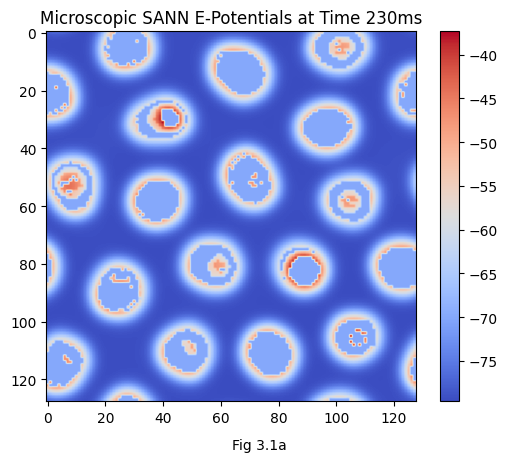

In [72]:
set_all_seeds(42)

#bump state configurations
M = 45 # 突触范围
En = 128 # 兴奋性神经元网格边长数
In = 128 # 抑制性神经元网格边长数，En与In之比需要为整数
runtime_in = 30  # 有外界输入的时间
runtime = 200  # 自发动力学的时间
rp = 5  # 不应期时间
We = 0.23  # 兴奋性连接权重
Wi = 0.06 # 抑制性连接权重

dt = 0.5  # 模拟时间步长 ms
__t__ = 0  # 全局时间变量，用于计算不应期

# Collect data from the original model
E_potentials_SANN, E_spikes_SANN, I_spikes_SANN = [], [], []

SANN = SpikingAttractorNetwork(En,In,rp=rp,We=We,Wi=Wi,M=M)

# Simulation with external input
for i in tqdm(range(int(runtime_in/dt))):
    __t__ += dt
    E_potential, E_spike, I_potential, I_spike = SANN.update(torch.rand((En,En)).to(device)*5, torch.rand((In,In)).to(device)*5)
    E_potentials_SANN.append(E_potential.clone().cpu())
    E_spikes_SANN.append(E_spike.clone().cpu())
    I_spikes_SANN.append(I_spike.clone().cpu())

# Simulation without external input
for i in tqdm(range(int(runtime/dt))):
    __t__ += dt
    E_potential, E_spike, I_potential, I_spike = SANN.update(torch.rand((En,En)).to(device)*0, torch.rand((In,In)).to(device)*0)
    E_potentials_SANN.append(E_potential.clone().cpu())
    E_spikes_SANN.append(E_spike.clone().cpu())
    I_spikes_SANN.append(I_spike.clone().cpu())

plt.imshow(E_potentials_SANN[-1].cpu(), cmap='coolwarm')
plt.title(f'Microscopic SANN E-Potentials at Time 230ms')
plt.colorbar()
plt.figtext(0.5, 0.01, 'Fig 3.1a', ha='center', fontsize=10)
plt.show()

100%|██████████████████████████████████████████████████████████████████████████████| 460/460 [00:00<00:00, 7589.65it/s]


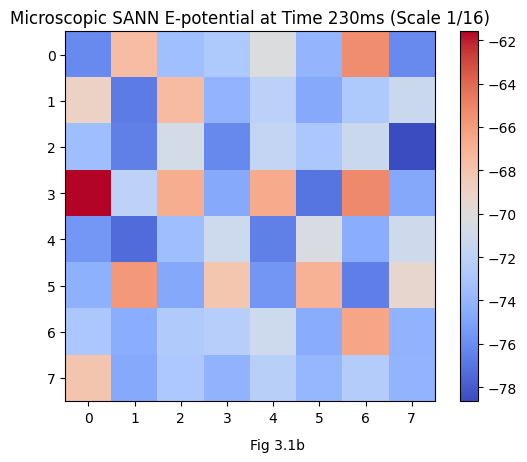

In [71]:
#downscaled by factor 16
ds = 16
E_potentials_SANN_downscaled = []
for i in tqdm(range(len(E_potentials_SANN))):
    E_potentials_SANN_downscaled.append(downscale_activity(E_potentials_SANN[i], ds).cpu())

plt.imshow(E_potentials_SANN_downscaled[-1], cmap='coolwarm')
plt.title(f'Microscopic SANN E-potential at Time {runtime_in+runtime}ms (Scale 1/{ds})')
plt.colorbar()
plt.figtext(0.5, 0.01, 'Fig 3.1b', ha='center', fontsize=10)
plt.show()

In [7]:
# Macroscopic Spiking Attractor Neural Network
class MacroLIFlayer:
    def __init__(self, n:int, threshold=-50.0, reset_value=-70.0, 
                 membrane_capacitance=1.0, gL=0.05, refractory_period=5):
        """
        A LIF layer on a smaller grid (n,n).
        """
        self.shape = (n,n)
        self.threshold = threshold
        self.reset_value = reset_value
        self.membrane_capacitance = membrane_capacitance
        self.gL = gL
        self.refractory = refractory_period

        self.potential = torch.ones(self.shape, device=device) * self.reset_value
        self.spike = torch.zeros(self.shape, device=device)
        self.spike_time = torch.ones(self.shape, device=device) * (-self.refractory * 5)

    def update(self, input_current: torch.Tensor):
        assert input_current.shape == self.shape

        global dt, __t__  # reuse your global dt, time
        # LIF membrane update
        dV = dt * (input_current - self.gL*(self.potential - self.reset_value)) / self.membrane_capacitance
        self.potential += dV

        # Enforce refractory
        can_fire = (__t__ > (self.spike_time + self.refractory))
        self.potential = torch.where(
            can_fire, 
            self.potential, 
            torch.full(self.shape, self.reset_value, device=device)
        )

        # Spikes
        self.spike = (self.potential > self.threshold) & can_fire

        # Update last spike time
        self.spike_time = torch.where(
            self.spike, 
            torch.full(self.shape, __t__, device=device),
            self.spike_time
        )

        return self.potential, self.spike


class MacroSynapseslayer:
    def __init__(self, in_neuron:int, out_neuron:int, m_synapses:int,
                 W=0.02, sigma=18, time_constant=3.0, Vrest=0.0):
        """
        A smaller synapse layer connecting (in_neuron x in_neuron) to (out_neuron x out_neuron).
        m_synapses must be odd.
        """
        self.in_neurons = in_neuron
        self.out_neurons = out_neuron
        self.shape = (out_neuron, out_neuron, m_synapses, m_synapses)
        self.time_constant = time_constant
        self.weight = self._build_gaussian(m_synapses, W, sigma)
        self.Vrest = Vrest

        self.g = torch.zeros(self.shape, device=device)
        self.i = torch.zeros(self.shape, device=device)

    def _build_gaussian(self, n, W, sigma):
        center = n // 2
        arr = np.zeros((n,n), dtype=np.float32)
        for x in range(n):
            for y in range(n):
                r2 = (x - center)**2 + (y - center)**2
                arr[x, y] = W * np.exp(-r2 / sigma)
        return torch.tensor(arr, device=device)

    def update(self, spike_in: torch.Tensor, pot_out: torch.Tensor):
        """
        Equivalent to original 'update':
          - decays synaptic conductance
          - add new conduction from spikes
          - compute current = -g * (V - Vrest)
        """
        global dt

        assert spike_in.shape == (self.in_neurons, self.in_neurons)

        # Decay conduction
        self.g -= dt * self.g / self.time_constant

        # Unfold/scale as needed. We'll do the same scale_up/scale_down approach
        if self.in_neurons < self.out_neurons:
            spike_in = self.scale_up(spike_in, self.out_neurons // self.in_neurons)
        else:
            spike_in = self.scale_down(spike_in, self.in_neurons // self.out_neurons)

        # Add new conduction
        # shape(weight) = (m,m)
        # shape(spike_in) = (outN, outN, m,m)
        # time_constant in denominator is arbitrary or from your code
        self.g += dt * torch.einsum('ij,klij->klij', self.weight, spike_in / self.time_constant)

        # i = - g * (V_out - Vrest)
        m = self.weight.shape[0]
        pot_4d = pot_out.unsqueeze(2).unsqueeze(3).repeat(1,1,m,m)
        self.i = - self.g * (pot_4d - self.Vrest)

        return self.i

    def scale_up(self, input: torch.Tensor, zoom_rate: int):
        a1 = self.shape[3] // 2
        a2 = (self.shape[3] - 1)//2

        # same approach as your original
        input = torch.cat((input, input[:,:a1]), dim=1)
        input = torch.cat((input[:,-a1-a2:-a1], input), dim=1)
        input = torch.cat((input, input[:a1,:]), dim=0)
        input = torch.cat((input[-a2-a1:-a1,:], input), dim=0)

        input = input.unfold(0, self.shape[2], 1).unfold(1, self.shape[3], 1)
        input = input.repeat_interleave(zoom_rate,dim=0).repeat_interleave(zoom_rate,dim=1)
        return input

    def scale_down(self, input: torch.Tensor, zoom_rate: int):
        a1 = self.shape[3]//2
        a2 = (self.shape[3]-1)//2

        input = torch.cat((input, input[:,:a1]), dim=1)
        input = torch.cat((input[:,-a1-a2:-a1], input), dim=1)
        input = torch.cat((input, input[:a1,:]), dim=0)
        input = torch.cat((input[-a2-a1:-a1,:], input), dim=0)

        input = input.unfold(0, self.shape[2], zoom_rate).unfold(1, self.shape[3], zoom_rate)
        return input

class MacroscopicSpikingAttractorNetwork:
    def __init__(self, En_small, In_small, rp, We, Wi, M):
        self.E_neurons = MacroLIFlayer(n=En_small, refractory_period=rp)
        self.synapsesEE = MacroSynapseslayer(En_small, En_small, M, W=We)
        self.synapsesEI = MacroSynapseslayer(En_small, In_small, M, W=We)

        self.I_neurons = MacroLIFlayer(n=In_small, refractory_period=rp)
        self.synapsesIE = MacroSynapseslayer(In_small, En_small, M, Vrest=-80, sigma=400, W=Wi)
        self.synapsesII = MacroSynapseslayer(In_small, In_small, M, Vrest=-80, sigma=400, W=Wi)

    def update(self, inputE: torch.Tensor, inputI: torch.Tensor):
        # LIF updates for E, I
        E_potential, E_spike = self.E_neurons.update(
            inputE + self.synapsesEE.i.sum(dim=(2,3)) + self.synapsesIE.i.sum(dim=(2,3))
        )
        I_potential, I_spike = self.I_neurons.update(
            inputI + self.synapsesII.i.sum(dim=(2,3)) + self.synapsesEI.i.sum(dim=(2,3))
        )
        # Synapse updates
        self.synapsesEE.update(E_spike, E_potential)
        self.synapsesEI.update(E_spike, I_potential)
        self.synapsesIE.update(I_spike, E_potential)
        self.synapsesII.update(I_spike, I_potential)

        return E_potential, E_spike, I_potential, I_spike

100%|███████████████████████████████████████████████████████████████████████████████| 460/460 [00:01<00:00, 283.95it/s]


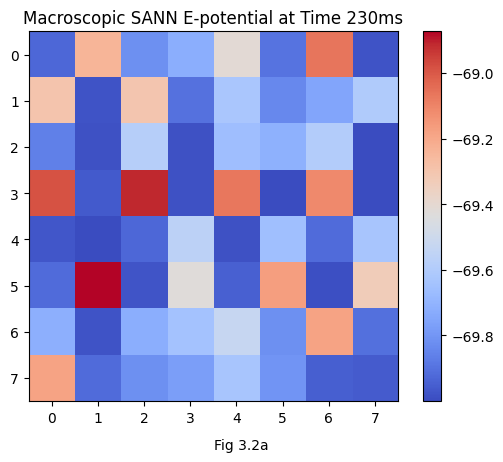

In [73]:
set_all_seeds(42)

# downscale factor
En_small = En // ds
In_small = In // ds
M_small = M // ds    # or keep M_small = M if you want the same kernel size

# Create the macroscopic network
MSANN = MacroscopicSpikingAttractorNetwork(
    En_small=En_small,
    In_small=In_small,
    rp=rp,
    We=We,
    Wi=Wi,
    M=M_small
)

# We'll store results from the macro net
E_potentials_MSANN, E_spikes_MSANN = [], []

__t__ = 0.0
dt = 0.5

# Simulation with E,I spikes from original SANN
for i in tqdm(range(len(E_spikes_SANN))):
    __t__ += dt
    e_small = downscale_activity(E_spikes_SANN[i].clone().detach(), ds).to(device)
    i_small = downscale_activity(I_spikes_SANN[i].clone().detach(), ds).to(device)
    E_potential, E_spike, I_potential, I_spike = MSANN.update(e_small, i_small)
    E_potentials_MSANN.append(E_potential.clone().cpu())
    E_spikes_MSANN.append(E_spike.clone().cpu())

# Example: visualize final macroscopic excitatory potential
import matplotlib.pyplot as plt
plt.imshow(E_potentials_MSANN[-1], cmap='coolwarm')
plt.title(f'Macroscopic SANN E-potential at Time {runtime_in+runtime}ms')
plt.colorbar()
plt.figtext(0.5, 0.01, 'Fig 3.2a', ha='center', fontsize=10)
plt.show()

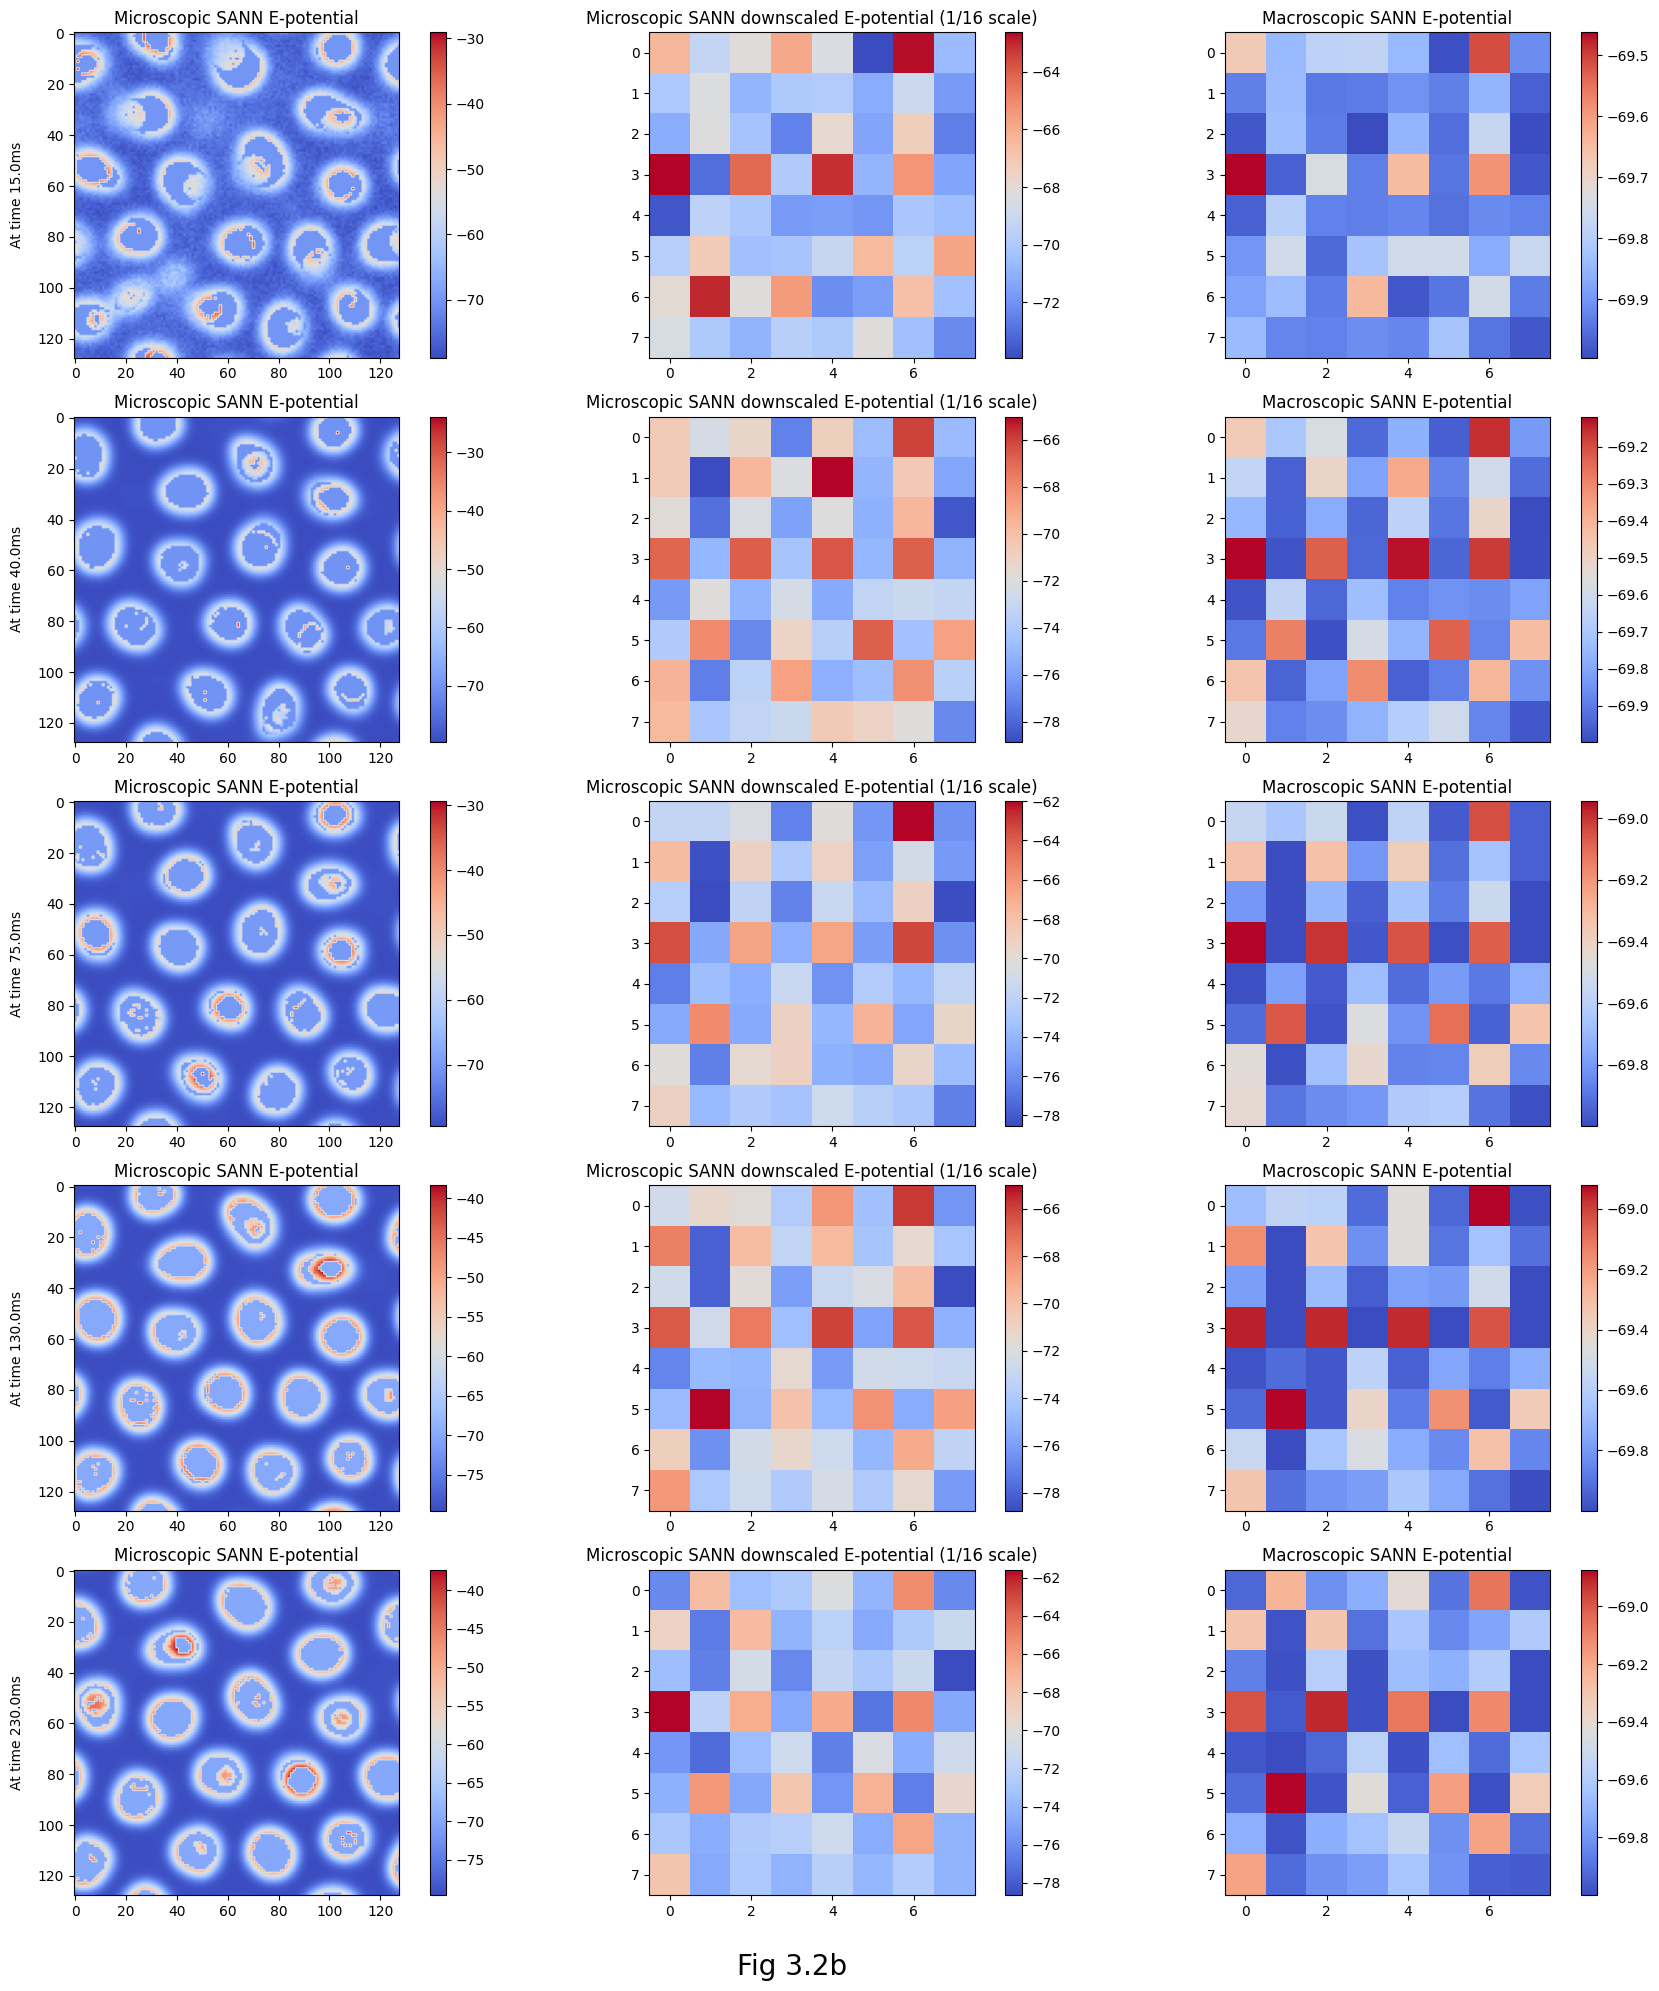

In [87]:
# compare downscale e-potential
steps = [29, 79, 149, 259, 459]
fig, axes = plt.subplots(nrows=len(steps), ncols=3, figsize=(18, 20))

for row_idx, step in enumerate(steps):
    # --- 1) Microscopic E-potential
    im0 = axes[row_idx, 0].imshow(E_potentials_SANN[step], cmap='coolwarm')
    axes[row_idx, 0].set_title(f"Microscopic SANN E-potential")
    fig.colorbar(im0, ax=axes[row_idx, 0])

    # --- 2) Microscopic Downscaled E-potential
    im1 = axes[row_idx, 1].imshow(E_potentials_SANN_downscaled[step], cmap='coolwarm')
    axes[row_idx, 1].set_title(f"Microscopic SANN downscaled E-potential (1/{ds} scale)")
    fig.colorbar(im1, ax=axes[row_idx, 1])

    # --- 3) Macroscopic E-potential (SANN)
    im2 = axes[row_idx, 2].imshow(E_potentials_MSANN[step], cmap='coolwarm')
    axes[row_idx, 2].set_title("Macroscopic SANN E-potential")
    fig.colorbar(im2, ax=axes[row_idx, 2])

    # Label the row with the time
    # (Rotate label 90 degrees if you want a vertical label)
    axes[row_idx, 0].set_ylabel(f"At time {(step+1)*dt}ms", rotation=90, labelpad=10)

plt.tight_layout()
plt.subplots_adjust(bottom=0.05)
plt.figtext(0.5, 0.01, 'Fig 3.2b', ha='center', fontsize=20)
plt.show()

In [91]:
# cosine similarity of downscaled E-potentials
print("Cosine Similarity of downscaled Microscopic SANN and Macroscopic SANN E-Potentials:")
for s in steps:
    t1 = normalize(E_potentials_SANN_downscaled[s])
    t2 = normalize(E_potentials_MSANN[s])
    
    cos_sim = cosine_similarity(t1, t2)
    
    print(f"Time {(s+1)*dt}ms")
    print(f"Cosine Similarity: {cos_sim:.4f}\n")

Cosine Similarity of downscaled Microscopic SANN and Macroscopic SANN E-Potentials:
Time 15.0ms
Cosine Similarity: 0.9400

Time 40.0ms
Cosine Similarity: 0.9490

Time 75.0ms
Cosine Similarity: 0.9522

Time 130.0ms
Cosine Similarity: 0.9298

Time 230.0ms
Cosine Similarity: 0.9424



In [90]:
# cosine similarity of downscaled E-potentials
print("Cosine Similarity of Microscopic SANN and upscaled Macroscopic SANN E-Potentials:")
for s in steps:
    t1 = normalize(E_potentials_SANN[s])
    t2 = normalize(E_potentials_MSANN_upscaled[s])
    
    cos_sim = cosine_similarity(t1, t2)
    
    print(f"Time {(s+1)*dt}ms")
    print(f"Cosine Similarity: {cos_sim:.4f}\n")

Cosine Similarity of Microscopic SANN and upscaled Macroscopic SANN E-Potentials:
Time 15.0ms
Cosine Similarity: 0.7168

Time 40.0ms
Cosine Similarity: 0.6941

Time 75.0ms
Cosine Similarity: 0.6929

Time 130.0ms
Cosine Similarity: 0.6747

Time 230.0ms
Cosine Similarity: 0.6985



100%|██████████████████████████████████████████████████████████████████████████████| 460/460 [00:00<00:00, 6014.22it/s]


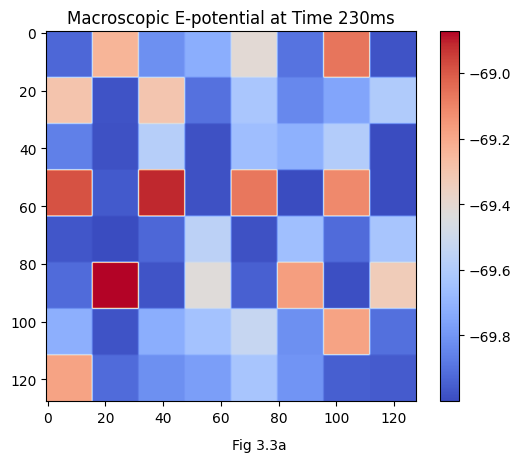

In [82]:
# upscale
E_potentials_MSANN_upscaled = []
for i in tqdm(range(len(E_potentials_MSANN))):
    E_potentials_MSANN_upscaled.append(upscale_activity(E_potentials_MSANN[i], ds).cpu())

plt.imshow(E_potentials_MSANN_upscaled[-1], cmap='coolwarm')
plt.title(f'Macroscopic E-potential at Time {runtime_in+runtime}ms')
plt.colorbar()
plt.figtext(0.5, 0.01, 'Fig 3.3a', ha='center', fontsize=10)
plt.show()

In [11]:
set_all_seeds(42)

train_dataset = EpotentialsDataset(E_potentials_MSANN_upscaled, E_potentials_SANN, device=device)
unet = UNet2D().to(device)

train_unet(
    unet, 
    train_dataset,
    num_epochs=10,
    batch_size=4,
    lr=1e-3
)

C:\Users\CyberCraze\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
 10%|████████▎                                                                          | 1/10 [00:18<02:47, 18.61s/it]

Epoch [1/10], Loss: 4882.390016


 20%|████████████████▌                                                                  | 2/10 [00:29<01:54, 14.32s/it]

Epoch [2/10], Loss: 4158.695138


 30%|████████████████████████▉                                                          | 3/10 [00:40<01:29, 12.82s/it]

Epoch [3/10], Loss: 3174.688311


 40%|█████████████████████████████████▏                                                 | 4/10 [00:46<01:00, 10.05s/it]

Epoch [4/10], Loss: 2140.481403


 50%|█████████████████████████████████████████▌                                         | 5/10 [00:52<00:42,  8.47s/it]

Epoch [5/10], Loss: 1250.128074


 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:58<00:30,  7.53s/it]

Epoch [6/10], Loss: 619.733271


 70%|██████████████████████████████████████████████████████████                         | 7/10 [01:03<00:20,  6.90s/it]

Epoch [7/10], Loss: 256.516369


 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [01:09<00:12,  6.50s/it]

Epoch [8/10], Loss: 88.282138


 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [01:15<00:06,  6.27s/it]

Epoch [9/10], Loss: 34.594185


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:20<00:00,  8.08s/it]

Epoch [10/10], Loss: 21.402557
Training complete.


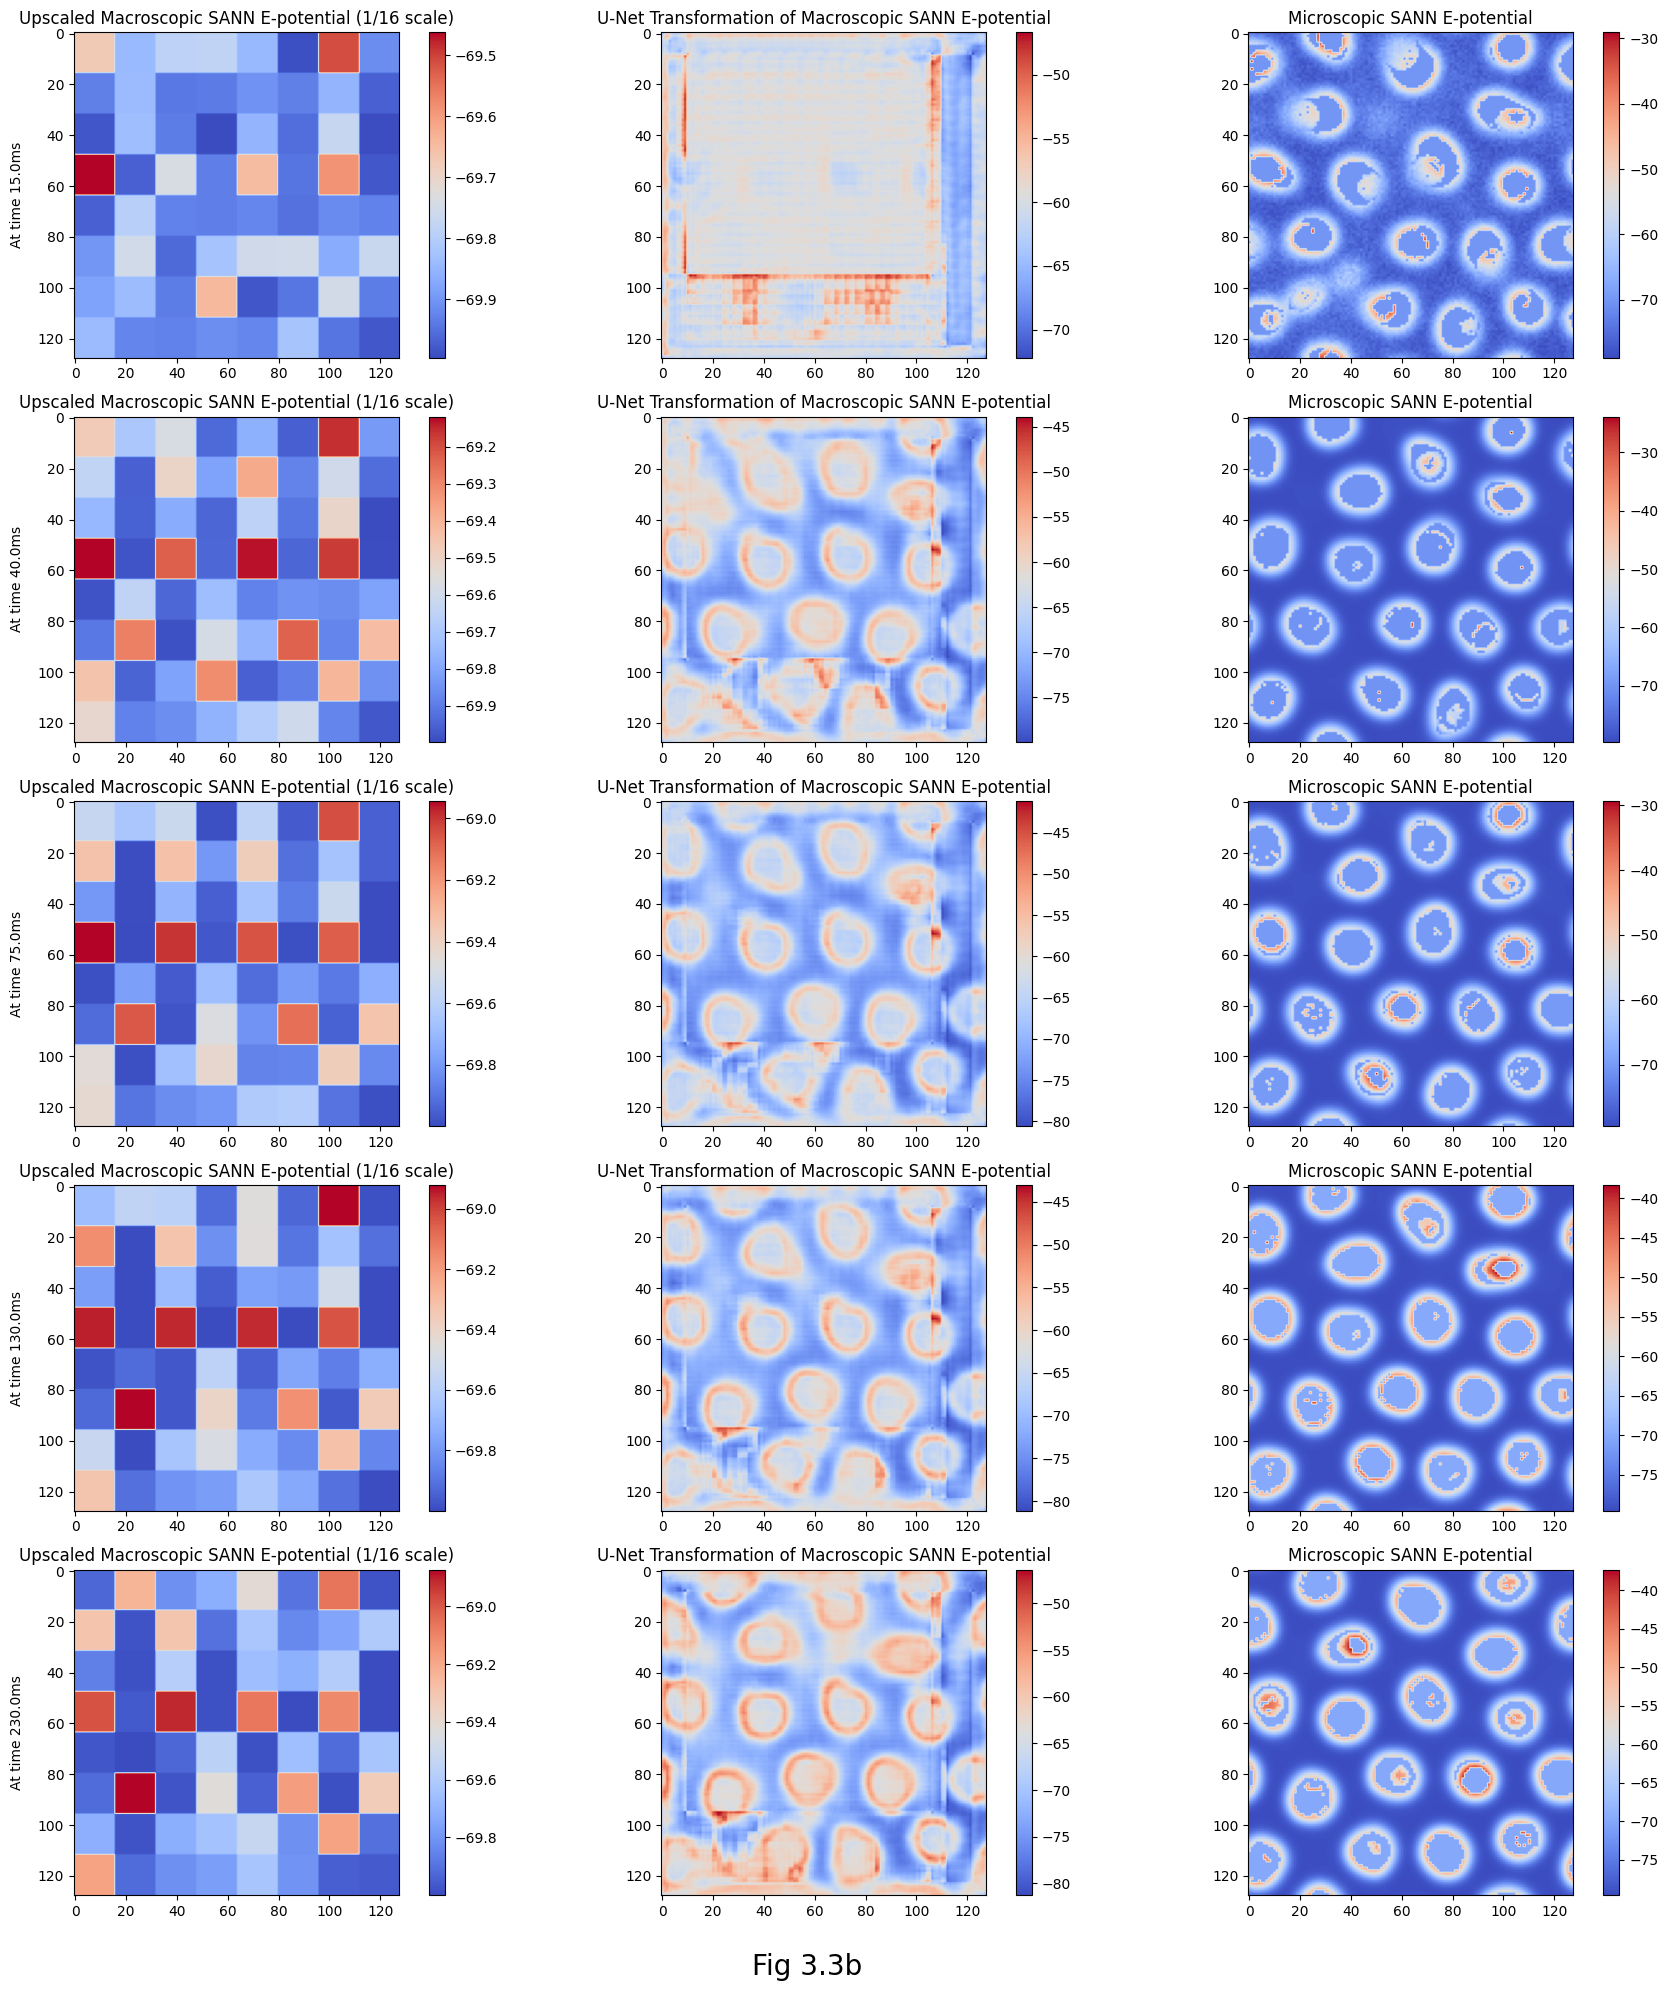

In [86]:
steps = [29, 79, 149, 259, 459]
fig, axes = plt.subplots(nrows=len(steps), ncols=3, figsize=(18, 20))

for row_idx, step in enumerate(steps):
    # --- 1) Upscaled macroscopic E-potential
    im0 = axes[row_idx, 0].imshow(upscale_activity(E_potentials_MSANN[step], ds), cmap='coolwarm')
    axes[row_idx, 0].set_title(f"Upscaled Macroscopic SANN E-potential (1/{ds} scale)")
    fig.colorbar(im0, ax=axes[row_idx, 0])

    # --- 2) U-Net upscaled E-potential
    im1 = axes[row_idx, 1].imshow(unet_upscale(unet, E_potentials_MSANN_upscaled[step]), cmap='coolwarm')
    axes[row_idx, 1].set_title("U-Net Transformation of Macroscopic SANN E-potential")
    fig.colorbar(im1, ax=axes[row_idx, 1])

    # --- 3) Microscopic E-potential (SANN)
    im2 = axes[row_idx, 2].imshow(E_potentials_SANN[step], cmap='coolwarm')
    axes[row_idx, 2].set_title("Microscopic SANN E-potential")
    fig.colorbar(im2, ax=axes[row_idx, 2])

    # Label the row with the time
    # (Rotate label 90 degrees if you want a vertical label)
    axes[row_idx, 0].set_ylabel(f"At time {(step+1)*dt}ms", rotation=90, labelpad=10)

plt.tight_layout()
plt.subplots_adjust(bottom=0.05)
plt.figtext(0.5, 0.01, 'Fig 3.3b', ha='center', fontsize=20)
plt.show()

In [88]:
# cosine similarity of upscaled E-potentials
print("Cosine Similarity of unet upscaled Macroscopic SANN and Microscopic SANN E-Potentials:")
for s in steps:
    t1 = normalize(E_potentials_SANN[s])
    t2 = normalize(torch.tensor(unet_upscale(unet, E_potentials_MSANN_upscaled[step])))
    
    cos_sim = cosine_similarity(t1, t2)
    
    print(f"Time {(s+1)*dt}ms")
    print(f"Cosine Similarity: {cos_sim:.4f}\n")

Cosine Similarity of unet upscaled Macroscopic SANN and Microscopic SANN E-Potentials:
Time 15.0ms
Cosine Similarity: 0.8027

Time 40.0ms
Cosine Similarity: 0.7520

Time 75.0ms
Cosine Similarity: 0.7601

Time 130.0ms
Cosine Similarity: 0.7933

Time 230.0ms
Cosine Similarity: 0.7925



In [94]:
# cosine similarity of downscaled E-potentials
print("Cosine Similarity of Microscopic SANN and upscaled Macroscopic SANN E-Potentials")
print("Before -> After U-Net Transformation:")
for s in steps:
    t1 = normalize(E_potentials_SANN[s])
    t2 = normalize(E_potentials_MSANN_upscaled[s])
    t3 = normalize(torch.tensor(unet_upscale(unet, E_potentials_MSANN_upscaled[step])))
    
    cos_sim = cosine_similarity(t1, t2)
    cos_sim2 = cosine_similarity(t1, t3)
    
    print(f"Time {(s+1)*dt}ms")
    print(f"Cosine Similarity: {cos_sim:.4f} -> {cos_sim2:.4f}\n")

Cosine Similarity of Microscopic SANN and upscaled Macroscopic SANN E-Potentials
Before -> After U-Net Transformation:
Time 15.0ms
Cosine Similarity: 0.7168 -> 0.8027

Time 40.0ms
Cosine Similarity: 0.6941 -> 0.7520

Time 75.0ms
Cosine Similarity: 0.6929 -> 0.7601

Time 130.0ms
Cosine Similarity: 0.6747 -> 0.7933

Time 230.0ms
Cosine Similarity: 0.6985 -> 0.7925

